In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import math
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

Arrythmia Dataset
- Number of samples: 109446
- Number of categories: 5
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrythmia Dataset

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Set seeds
seed_value = 0
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data exploration

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/nn_group/mitbih_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/nn_group/mitbih_test.csv')

In [6]:
print(f"Shape of train data: {train_df.shape}")
print(f"Shape of test data: {test_df.shape}")

Shape of train data: (87553, 188)
Shape of test data: (21891, 188)


In [7]:
# If your dataframes don't have column names, assign them
# This creates columns named '0', '1', '2', ...
train_df.columns = [str(i) for i in range(train_df.shape[1])]
test_df.columns = [str(i) for i in range(test_df.shape[1])]

In [8]:
print(f"NaN values in train data: {train_df.isna().sum().sum()}")
print(f"NaN values in test data: {test_df.isna().sum().sum()}")

NaN values in train data: 0
NaN values in test data: 0


In [9]:
# Last column stores the labels
print(train_df.iloc[:, -1].unique())
print(test_df.iloc[:, -1].unique())

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]


In [10]:
train_df.iloc[:, -1].value_counts()

,count
187,
0.0,72470
4.0,6431
2.0,5788
1.0,2223
3.0,641


In [11]:
test_df.iloc[:, -1].value_counts()

,count
187,
0.0,18117
4.0,1608
2.0,1448
1.0,556
3.0,162


From the counts of the classes, we can observe that the dataset is imbalanced, as class = 0 makes up a large proportion of the training (82.77%) and test data (82.76%). However, we will go ahead with training and evaluating for now and observe the results.

## Generating Training Data

In [12]:
df_train, df_val = train_test_split(train_df, test_size=0.2, random_state=0)
print(df_train.shape)
print(df_val.shape)

(70042, 188)
(17511, 188)


In [13]:
x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

x_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_val = torch.tensor(x_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

## Hybrid CNN-RNN Model

In [46]:
# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the classifier with a linear layer
class Classifier(nn.Module):
    def __init__(self, encoding_dim, num_classes):
        super(Classifier, self).__init__()
        self.classifier = nn.Linear(encoding_dim, num_classes)

    def forward(self, x):
        return self.classifier(x)

# Classifier with MLP
class ClassifierMLP(nn.Module):
    def __init__(self, encoding_dim, num_classes):
        super(ClassifierMLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [47]:
def train_autoencoder_loop(train_dataloader, autoencoder, loss_fn, optimizer):
    autoencoder.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss = 0

    for batch, (X, _) in enumerate(train_dataloader):  # No labels needed for reconstruction
        # Move inputs to the same device as the model (GPU or CPU)
        X = X.to(device)

        # Forward pass: Encode and decode
        _, reconstructed = autoencoder(X)
        loss = loss_fn(reconstructed, X)  # Compute reconstruction loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    return train_loss

def test_autoencoder_loop(test_dataloader, autoencoder, loss_fn):
    autoencoder.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, _ in test_dataloader:
            X = X.to(device)

            # Forward pass: Encode and decode
            _, reconstructed = autoencoder(X)
            test_loss += loss_fn(reconstructed, X).item()  # Compute reconstruction loss

    test_loss /= num_batches
    return test_loss

In [48]:
def train_classifier_loop(train_dataloader, encoder, classifier, loss_fn, optimizer):
    encoder.eval()  # Freeze the encoder during classifier training
    classifier.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss, train_correct = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Extract features from the encoder
        with torch.no_grad():
            features = encoder(X)

        # Forward pass through the classifier
        outputs = classifier(features)
        loss = loss_fn(outputs, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y).sum().item()

    train_loss /= num_batches
    train_correct /= size
    return train_loss, train_correct

def test_classifier_loop(test_dataloader, encoder, classifier, loss_fn):
    encoder.eval()
    classifier.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Extract features using the encoder
            features = encoder(X)

            # Forward pass through the classifier
            outputs = classifier(features)
            test_loss += loss_fn(outputs, y).item()

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == y).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct, np.array(all_preds), np.array(all_labels)

In [49]:
class EarlyStopper:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

## Training & Evaluation of Model

In [55]:
input_dim = 187
encoding_dim = 128
num_classes = 5

patience = 3
no_epochs = 100
batch_size = 64
lr = 0.001

In [56]:
# Define the autoencoder training function
def train_autoencoder(autoencoder, x_train, y_train, x_test, y_test, num_epochs=20, learning_rate=0.001):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    # Convert data to TensorDataset for DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Loaders for batching
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        # Train on the training dataset
        train_loss = train_autoencoder_loop(train_loader, autoencoder, loss_fn, optimizer)

        # Evaluate on the test dataset
        test_loss = test_autoencoder_loop(test_loader, autoencoder, loss_fn)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:>8f}, Val Loss: {test_loss:>8f}")

        if early_stopper.early_stop(test_loss):
          print('Done')
          break

# Define the classifier training function
def train_classifier(encoder, classifier, x_train, y_train, x_test, y_test, num_epochs=20, learning_rate=0.001):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    # Convert data to TensorDataset for DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Loaders for batching
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        # Train on the training dataset
        train_loss, train_accuracy = train_classifier_loop(train_loader, encoder, classifier, loss_fn, optimizer)

        # Evaluate on the test dataset
        test_loss, test_accuracy, _, _ = test_classifier_loop(test_loader, encoder, classifier, loss_fn)

        print(f"Epoch [{epoch+1}/{num_epochs}],  Train Acc: {train_accuracy*100:.2f}%, Train Loss: {train_loss:>8f}, "
              f"Val Acc: {test_accuracy*100:.2f}%, Val Loss: {test_loss:>8f}")

        if early_stopper.early_stop(test_loss):
          print('Done')
          break

In [57]:
# Model initialization
autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=187, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=187, bias=True)
    (3): Sigmoid()
  )
)

In [58]:
# Model initialization
classifier = Classifier(encoding_dim=encoding_dim, num_classes=num_classes).to(device)
classifier

Classifier(
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)

In [59]:
# Train the autoencoder
print("Training Autoencoder")
train_autoencoder(autoencoder, x_train, y_train, x_val, y_val, num_epochs=no_epochs, learning_rate=lr)

# Train the classifier (using the encoder from the trained autoencoder)
print("Training Single Linear Layer Classifier with encoder from trained autoencoder")
train_classifier(autoencoder.encoder, classifier, x_train, y_train, x_val, y_val, num_epochs=no_epochs, learning_rate=lr)

Training Autoencoder
Epoch [1/100], Train Loss: 0.012058, Val Loss: 0.004243
Epoch [2/100], Train Loss: 0.003077, Val Loss: 0.002330
Epoch [3/100], Train Loss: 0.001944, Val Loss: 0.001667
Epoch [4/100], Train Loss: 0.001485, Val Loss: 0.001322
Epoch [5/100], Train Loss: 0.001231, Val Loss: 0.001196
Epoch [6/100], Train Loss: 0.001077, Val Loss: 0.001022
Epoch [7/100], Train Loss: 0.000964, Val Loss: 0.000950
Epoch [8/100], Train Loss: 0.000872, Val Loss: 0.000828
Epoch [9/100], Train Loss: 0.000810, Val Loss: 0.000830
Epoch [10/100], Train Loss: 0.000761, Val Loss: 0.000766
Epoch [11/100], Train Loss: 0.000719, Val Loss: 0.000714
Epoch [12/100], Train Loss: 0.000681, Val Loss: 0.000659
Epoch [13/100], Train Loss: 0.000651, Val Loss: 0.000669
Epoch [14/100], Train Loss: 0.000629, Val Loss: 0.000625
Epoch [15/100], Train Loss: 0.000606, Val Loss: 0.000602
Epoch [16/100], Train Loss: 0.000585, Val Loss: 0.000570
Epoch [17/100], Train Loss: 0.000568, Val Loss: 0.000560
Epoch [18/100], Tra

In [60]:
loss_fn = nn.CrossEntropyLoss()

# Convert data to TensorDataset for DataLoader
test_dataset = TensorDataset(x_test, y_test)

# Loaders for batching
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_loss, test_accuracy, all_preds, all_labels = test_classifier_loop(test_loader, autoencoder.encoder, classifier, loss_fn)
print("Single Linear Layer Classifier:")
print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

Single Linear Layer Classifier:
Test accuracy: 93.25%, Test loss: 0.252659


We can observe that the accuracy on the test set is very good. However, as we found earlier, the dataset is imbalanced, which may mean that the accuracy could be misleading and not reflect actual performance of the predictions for all classes.

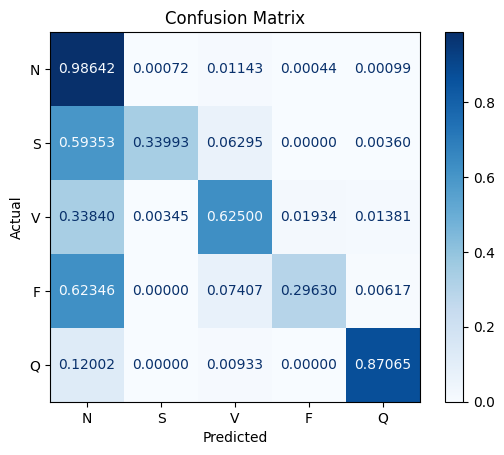

In [61]:
actual_labels = y_test.tolist()

class_labels = ["N", "S", "V", "F", "Q"]

cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".5f")

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [62]:
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.94      0.99      0.96     18117
           S       0.91      0.34      0.50       556
           V       0.77      0.62      0.69      1448
           F       0.57      0.30      0.39       162
           Q       0.97      0.87      0.92      1608

    accuracy                           0.93     21891
   macro avg       0.83      0.62      0.69     21891
weighted avg       0.93      0.93      0.93     21891



In [63]:
autoencoder1 = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
autoencoder1

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=187, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=187, bias=True)
    (3): Sigmoid()
  )
)

In [64]:
classifierMLP = ClassifierMLP(encoding_dim=encoding_dim, num_classes=num_classes).to(device)
classifierMLP

ClassifierMLP(
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [65]:
# Train the autoencoder
print("Training Autoencoder")
train_autoencoder(autoencoder1, x_train, y_train, x_val, y_val, num_epochs=no_epochs, learning_rate=lr)

Training Autoencoder
Epoch [1/100], Train Loss: 0.012630, Val Loss: 0.004324
Epoch [2/100], Train Loss: 0.003184, Val Loss: 0.002551
Epoch [3/100], Train Loss: 0.002039, Val Loss: 0.001796
Epoch [4/100], Train Loss: 0.001550, Val Loss: 0.001399
Epoch [5/100], Train Loss: 0.001264, Val Loss: 0.001186
Epoch [6/100], Train Loss: 0.001106, Val Loss: 0.001011
Epoch [7/100], Train Loss: 0.000971, Val Loss: 0.000951
Epoch [8/100], Train Loss: 0.000878, Val Loss: 0.000848
Epoch [9/100], Train Loss: 0.000810, Val Loss: 0.000782
Epoch [10/100], Train Loss: 0.000756, Val Loss: 0.000733
Epoch [11/100], Train Loss: 0.000717, Val Loss: 0.000715
Epoch [12/100], Train Loss: 0.000679, Val Loss: 0.000669
Epoch [13/100], Train Loss: 0.000652, Val Loss: 0.000647
Epoch [14/100], Train Loss: 0.000623, Val Loss: 0.000616
Epoch [15/100], Train Loss: 0.000600, Val Loss: 0.000658
Epoch [16/100], Train Loss: 0.000578, Val Loss: 0.000596
Epoch [17/100], Train Loss: 0.000557, Val Loss: 0.000597
Epoch [18/100], Tra

In [66]:
# Train the MLP classifier
print("Training MLP Classifier with encoder from trained autoencoder")
train_classifier(autoencoder1.encoder, classifierMLP, x_train, y_train, x_val, y_val, num_epochs=no_epochs, learning_rate=lr)

Training MLP Classifier with encoder from trained autoencoder
Epoch [1/100],  Train Acc: 91.99%, Train Loss: 0.283008, Val Acc: 96.03%, Val Loss: 0.149835
Epoch [2/100],  Train Acc: 95.16%, Train Loss: 0.172813, Val Acc: 96.61%, Val Loss: 0.126039
Epoch [3/100],  Train Acc: 95.75%, Train Loss: 0.150669, Val Acc: 96.66%, Val Loss: 0.115045
Epoch [4/100],  Train Acc: 96.09%, Train Loss: 0.139896, Val Acc: 96.77%, Val Loss: 0.113425
Epoch [5/100],  Train Acc: 96.19%, Train Loss: 0.132876, Val Acc: 97.10%, Val Loss: 0.101662
Epoch [6/100],  Train Acc: 96.39%, Train Loss: 0.127066, Val Acc: 97.13%, Val Loss: 0.098536
Epoch [7/100],  Train Acc: 96.65%, Train Loss: 0.120253, Val Acc: 97.04%, Val Loss: 0.100734
Epoch [8/100],  Train Acc: 96.69%, Train Loss: 0.117967, Val Acc: 97.26%, Val Loss: 0.093218
Epoch [9/100],  Train Acc: 96.70%, Train Loss: 0.114613, Val Acc: 97.30%, Val Loss: 0.092729
Epoch [10/100],  Train Acc: 96.91%, Train Loss: 0.110368, Val Acc: 97.36%, Val Loss: 0.091359
Epoch [

In [67]:
test_loss_mlp, test_accuracy_mlp, all_preds_mlp, all_labels_mlp = test_classifier_loop(test_loader, autoencoder1.encoder, classifierMLP, loss_fn)
print("MLPClassifier:")
print(f"Test accuracy: {(100*test_accuracy_mlp):>0.2f}%, Test loss: {test_loss_mlp:>8f}")

MLPClassifier:
Test accuracy: 97.34%, Test loss: 0.092593


In [68]:
report = classification_report(all_labels_mlp, all_preds_mlp, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.98      0.99      0.99     18117
           S       0.89      0.62      0.73       556
           V       0.93      0.91      0.92      1448
           F       0.88      0.49      0.63       162
           Q       0.99      0.97      0.98      1608

    accuracy                           0.97     21891
   macro avg       0.93      0.80      0.85     21891
weighted avg       0.97      0.97      0.97     21891

